### Dependencies

In [5]:
import glob
import numpy as np
import os
import collections
import sys

import pandas as pd
import pickle
import matplotlib
import matplotlib.pyplot as plt

import csv

import argparse
import yaml
import xgboost as xgb 

from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

%load_ext autoreload


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
with open('/project/ahoover/mhealth/zeyut/tmc/TMC AI Files/configs.yaml', 'r') as file:
    configs = yaml.safe_load(file)

#### XGBoost on static data

In [7]:
# Perform cross-validation
cv_configs = configs['cv_configs']
kf = KFold(n_splits=cv_configs['num_splits'], shuffle=True, random_state=cv_configs['random_seed'])

gt_path = configs['gt_path']
# Load ground truth labels and data
with open(configs['gt_path'], 'rb') as file:
    grades = pickle.load(file)
with open(os.path.join(configs['processed_data_path'], 'static_data.pkl'), 'rb') as file:
    static_data = pickle.load(file)
    
static_sc = list(static_data.keys())
sample_codes = list(grades['new'].keys())

In [8]:
results_path = os.path.join(configs['results_path'], 'static_model')
os.makedirs(results_path, exist_ok=True)

Old grading scheme
#class: 5 class sizes:
Counter({2: 15, 1: 14, 0: 8, 3: 7, 4: 3})
Accuracy: 0.3939393939393939
Precision: 0.3939393939393939
Recall: 0.3939393939393939


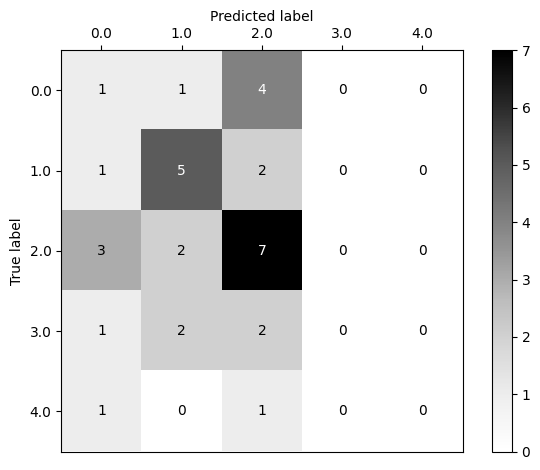

In [11]:
''' Old grading scheme
'''
print("Old grading scheme")

all_preds = np.array([])
all_labels = np.array([])
y_static = [grades['old'][sc] for sc in static_sc]
num_classes = len(np.unique(y_static))
print(f"#class: {num_classes}")
print(collections.Counter(y_static))

model = xgb.XGBClassifier(n_estimators=100,
                learning_rate=0.001,
                max_depth=5,
                subsample=0.8,
                colsample_bytree=0.9,
                objective='multi:softprob',
                num_class=len(np.unique(y_static)))

# Save detailed results for future analysis
file = open(os.path.join(results_path, 'result_1.csv'), mode='w', newline='')
writer = csv.writer(file)
# Write the header
writer.writerow(['Fold', 'Sample Code', 'Prediction', 'Ground Truth']+[f'P{class_}' for class_ in range(num_classes)])
# Loop through each fold
for fold, (train_index, test_index) in enumerate(kf.split(sample_codes)):
    x_train = []
    y_train = []
    for sc in np.array(sample_codes)[train_index]:
        if sc in static_sc:
            x_train.append(np.concatenate(static_data[sc], axis=0))
            y_train.append(grades['old'][sc])
    x_train = np.array(x_train)
    y_train = np.array(y_train)     

    x_test = []
    y_test = []
    sc_test = []
    for sc in np.array(sample_codes)[test_index]:
        if sc in static_sc:
            x_test.append(np.concatenate(static_data[sc], axis=0))
            y_test.append(grades['old'][sc])
            sc_test.append(sc)
    x_test = np.array(x_test)
    y_test = np.array(y_test)                

    classes = np.unique(y_train)  
    class_sizes = np.array(sorted(collections.Counter(y_train).values()))
    # computes the weight using inversed square root of class frequencies
    class_weights = 1/class_sizes**(0.5)
    sample_weights = np.array([class_weights[label] for label in y_train])

    model.fit(x_train, y_train, sample_weight=sample_weights)

    y_probs = model.predict_proba(x_test)
    y_pred = np.argmax(y_probs,axis=1)
    all_preds = np.concatenate((all_preds, y_pred))
    all_labels = np.concatenate((all_labels, y_test))

    for sc, pred, gt, probs in zip(sc_test, y_pred, y_test, y_probs):
        writer.writerow([fold+1, sc, pred, gt]+list(probs))
file.close()

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='micro')
recall = recall_score(all_labels, all_preds, average='micro')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

# Generate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(all_labels))
fig, ax = plt.subplots()
disp.plot(cmap=plt.cm.Greys, ax=ax)
ax.xaxis.set_label_position('top')  # Move the x-axis label to the top
ax.xaxis.tick_top()  # Move the x-axis ticks to the top
# plt.title('Confusion Matrix')
plt.tight_layout() 
plt.show()
fig.savefig('cm_static_old.jpg', dpi=300)


New grading scheme
#class: 3
Counter({1: 17, 0: 10, 2: 6})
5
6
6
9
7
Accuracy: 0.696969696969697
Precision: 0.696969696969697
Recall: 0.696969696969697


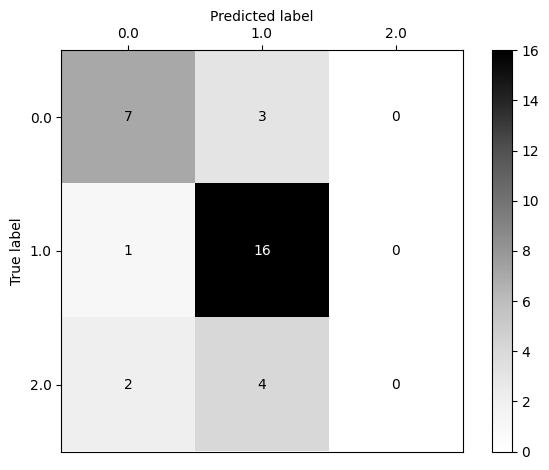

In [19]:
''' New grading scheme
'''
print("New grading scheme")
static_sc = list(static_data.keys())
all_preds = np.array([])
all_labels = np.array([])
y_static = [grades['new'][sc] for sc in static_sc]
num_classes = len(np.unique(y_static))
print(f"#class: {num_classes}")
print(collections.Counter(y_static))

model = xgb.XGBClassifier(n_estimators=10,
                learning_rate=0.001,
                max_depth=50,
                subsample=0.8,
                colsample_bytree=0.9,
                objective='multi:softprob',
                num_class=len(np.unique(y_static)))

# Save detailed results for future analysis
file = open(os.path.join(results_path, 'result_2.csv'), mode='w', newline='')
writer = csv.writer(file)
# Write the header
writer.writerow(['Fold', 'Sample Code', 'Prediction', 'Ground Truth']+[f'P{class_}' for class_ in range(num_classes)])

# Loop through each fold
for fold, (train_index, test_index) in enumerate(kf.split(sample_codes)):
    x_train = []
    y_train = []
    for sc in np.array(sample_codes)[train_index]:
        if sc in static_sc:
            x_train.append(np.concatenate(static_data[sc], axis=0))
            y_train.append(grades['new'][sc])
    x_train = np.array(x_train)
    y_train = np.array(y_train)     

    x_test = []
    y_test = []
    sc_test = []
    for sc in np.array(sample_codes)[test_index]:
        if sc in static_sc:
            x_test.append(np.concatenate(static_data[sc], axis=0))
            y_test.append(grades['new'][sc])
            sc_test.append(sc)
    x_test = np.array(x_test)
    y_test = np.array(y_test)                

    classes = np.unique(y_train)  
    # computes the weight using inversed square root of class frequencies
    class_sizes = np.array(sorted(collections.Counter(y_train).values()))
    class_weights = 1/class_sizes**(0.5)
    sample_weights = np.array([class_weights[label] for label in y_train])

    model.fit(x_train, y_train, sample_weight=sample_weights)

    y_probs = model.predict_proba(x_test)
    y_pred = np.argmax(y_probs,axis=1)
    print(len(y_pred))
    all_preds = np.concatenate((all_preds, y_pred))
    all_labels = np.concatenate((all_labels, y_test))

    for sc, pred, gt, probs in zip(sc_test, y_pred, y_test, y_probs):
        writer.writerow([fold+1, sc, pred, gt]+list(probs))

file.close()     

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='micro')
recall = recall_score(all_labels, all_preds, average='micro')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

# Generate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(all_labels))
fig, ax = plt.subplots()
disp.plot(cmap=plt.cm.Greys, ax=ax)
ax.xaxis.set_label_position('top')  # Move the x-axis label to the top
ax.xaxis.tick_top()  # Move the x-axis ticks to the top
# plt.title('Confusion Matrix')
plt.tight_layout() 
plt.show()
fig.savefig('cm_static_new.jpg', dpi=300)

In [12]:
len(y_train)

26

In [14]:
len(grades['new'])

46